<a href="https://colab.research.google.com/github/Edimer/My_CloudComputing/blob/master/XGBS9_SideralN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

UNICEF Arm 2030 Vision #1: Flood Prediction in Malawi
=============================================
Edimer David Jaramillo   
Abril de 2020

## Instalando y cargando bibliotecas

In [0]:
install.packages("h2o", dependencies = TRUE)
install.packages("ParBayesianOptimization", dependencies = TRUE)
install.packages("mlr3verse", dependencies = TRUE)
library(tidyverse)
library(h2o)
library(ParBayesianOptimization)
library(mlr3verse)
library(rBayesianOptimization)

## Importando datos

In [0]:
load("/content/dataTrain.Rdata")
load("/content/dataTest.Rdata")

## Modelo XGBoost (Optimización Bayesiana)

In [0]:
# Iniciando h2o
h2o.init(nthreads = -1, port = 54321, max_mem_size = "10g")

# Train y Test h2o
df_train <- dataTrain %>%
   select(-Square_ID)

# Datos h2o
datos_h2o <- as.h2o(x = df_train, destination_frame = "datos_h2o")

particiones <- h2o.splitFrame(data = datos_h2o, ratios = c(0.8, 0.10),
                              seed = 123)
datos_train_h2o <- h2o.assign(data = particiones[[1]], key = "datos_train_h2o")
datos_val_h2o   <- h2o.assign(data = particiones[[2]], key = "datos_val_h2o")
datos_test_h2o  <- h2o.assign(data = particiones[[3]], key = "datos_test_h2o")

# Se define la variable respuesta y los predictores.
var_respuesta <- "target_2015"

# Para este modelo se emplean todos los predictores disponibles.
predictores   <- setdiff(h2o.colnames(datos_train_h2o), var_respuesta)

# Modelo XGB h2o (función de scoring para optimización bayesiana)
scoring_function <- function(learn_rate, max_depth, subsample,
                              min_rows, col_sample_rate, colsample_bytree,
                              gamma, ntrees) {
  nfolds <- 10                              
  metrica <- "RMSE"

  xgb <- h2o.xgboost(x = predictores
                  ,y = var_respuesta
                  ,training_frame = datos_train_h2o
                  ,validation_frame = datos_val_h2o
                  ,stopping_rounds = 50
                  ,stopping_metric = "RMSE"
                  ,distribution = "poisson"
                  ,score_tree_interval = 5
                  ,learn_rate=learn_rate
                  ,ntrees=ntrees
                  ,subsample = subsample
                  ,col_sample_rate = col_sample_rate
                  ,colsample_bytree = colsample_bytree
                  ,tree_method = "hist"
                  ,grow_policy = "lossguide"
                  ,booster = "gbtree"
                  ,gamma = gamma
                  ,nfolds = nfolds
                  ,seed = 123
                  ,max_depth = max_depth
                  ,min_rows = min_rows)
  
  score <- h2o.performance(model = xgb, xval = TRUE)@metrics[[metrica]]
  
  # Si la métrica es un error, dado que el proceso es de maximización, se convierte
  # en negativo.
  score <- -score
  return(list(Score = score))
}                 

## Búsqueda de hiperparámetros

In [0]:
limites <- list( 
              learn_rate  = c(0.01, 0.3),
              max_depth   = c(1L, 50L), 
              subsample = c(0.5, 1),
              min_rows = c(1L, 30L),
              col_sample_rate = c(0.4, 1),
              colsample_bytree = c(0.5, 1),
              gamma = c(1L, 10L),
              ntrees = c(100L, 10000L)
              )

## Optimización

In [0]:
set.seed(123)
bayes_opt <- BayesianOptimization(
              FUN = scoring_function, 
              bounds = limites,
              init_points = 4,
              n_iter = 10,
              acq = "ucb",
              kappa = 2.576,
              eps = 0.0,
              verbose = TRUE
            )

elapsed = 663.55	Round = 1	learn_rate = 0.0934	max_depth = 47.0000	subsample = 0.7757	min_rows = 21.0000	col_sample_rate = 0.5477	colsample_bytree = 0.9448	gamma = 7.0000	ntrees = 2963.0000	Value = -0.1118 
elapsed = 372.10	Round = 2	learn_rate = 0.2386	max_depth = 3.0000	subsample = 0.7283	min_rows = 18.0000	col_sample_rate = 0.4252	colsample_bytree = 0.8464	gamma = 7.0000	ntrees = 1556.0000	Value = -0.1160 
elapsed = 943.13	Round = 3	learn_rate = 0.1286	max_depth = 27.0000	subsample = 0.9784	min_rows = 4.0000	col_sample_rate = 0.5968	colsample_bytree = 0.8203	gamma = 6.0000	ntrees = 9634.0000	Value = -0.1002 
elapsed = 360.88	Round = 4	learn_rate = 0.2661	max_depth = 45.0000	subsample = 0.7267	min_rows = 27.0000	col_sample_rate = 0.9727	colsample_bytree = 0.9971	gamma = 6.0000	ntrees = 9033.0000	Value = -0.1138 
elapsed = 36.06	Round = 5	learn_rate = 0.2266	max_depth = 50.0000	subsample = 1.0000	min_rows = 12.0000	col_sample_rate = 0.8769	colsample_bytree = 0.5350	gamma = 5.0000	ntre

Warning message:
“did not converge in 10 iterations”


In [0]:
xgb

## Predicciones

In [126]:
# ============================= Predicciones ====================================== #

# Train
predichos_train <- h2o.predict(xgb, datos_train_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test (Train)
predichos_test <- h2o.predict(xgb, datos_test_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test (Submission)
predichos_subm <- h2o.predict(xgb, as.h2o(dataTest)) %>%
  as.data.frame() %>% pull(predict)
predichos_subm[predichos_subm > 1] <- 1 
dataTest %>% 
  select(Square_ID) %>% 
  mutate(target = predichos_subm) ->
  subm8


# Exportando predicciones
write.csv(subm8, file = "subm8.csv", row.names = FALSE)

RMSE <- function(pred, obs, na.rm = FALSE){
  sqrt(mean((pred - obs)^2, na.rm = na.rm))
}

data.frame(
  data = c("Train", "Test"),
  RMSE = c(RMSE(pred = predichos_train, obs = as.vector(datos_train_h2o$target)),
           RMSE(pred = predichos_test, obs = as.vector(datos_test_h2o$target)))
)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


data,RMSE
<fct>,<dbl>
Train,0.09572475
Test,0.10153891


## Importancia de variables

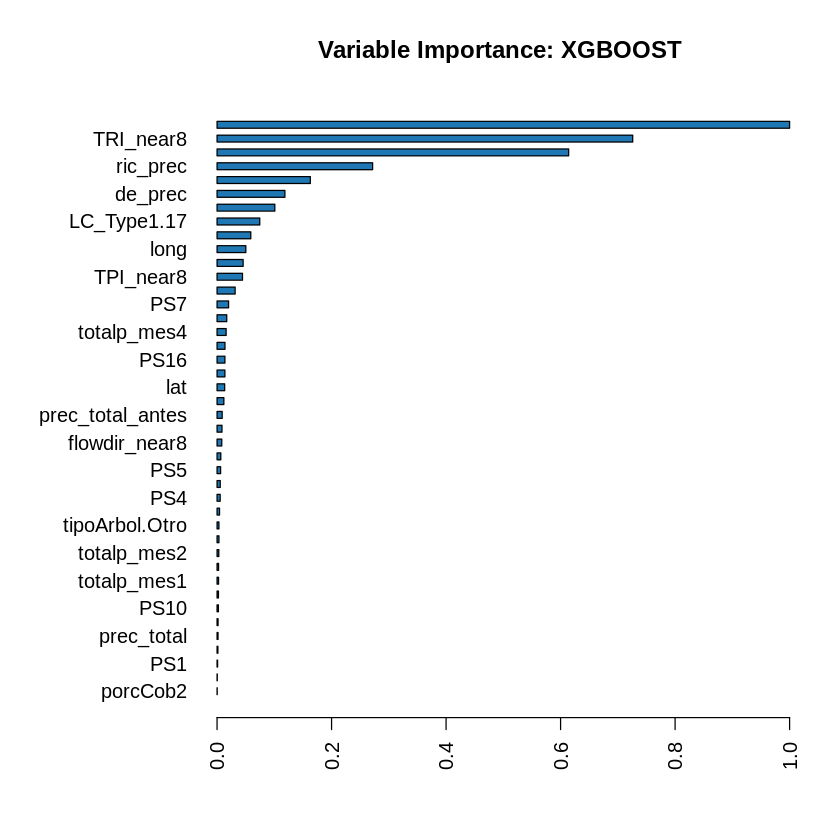

In [127]:
h2o.varimp_plot(xgb, num_of_features = ncol(dataTrain))

## Guardar modelo

In [128]:
h2o.saveModel(xgb, path = "XGB_Subm8", force = TRUE)

[1] "/content/XGB_Subm8/xgb_s8"

## Gráficos

  |======================================================================| 100%


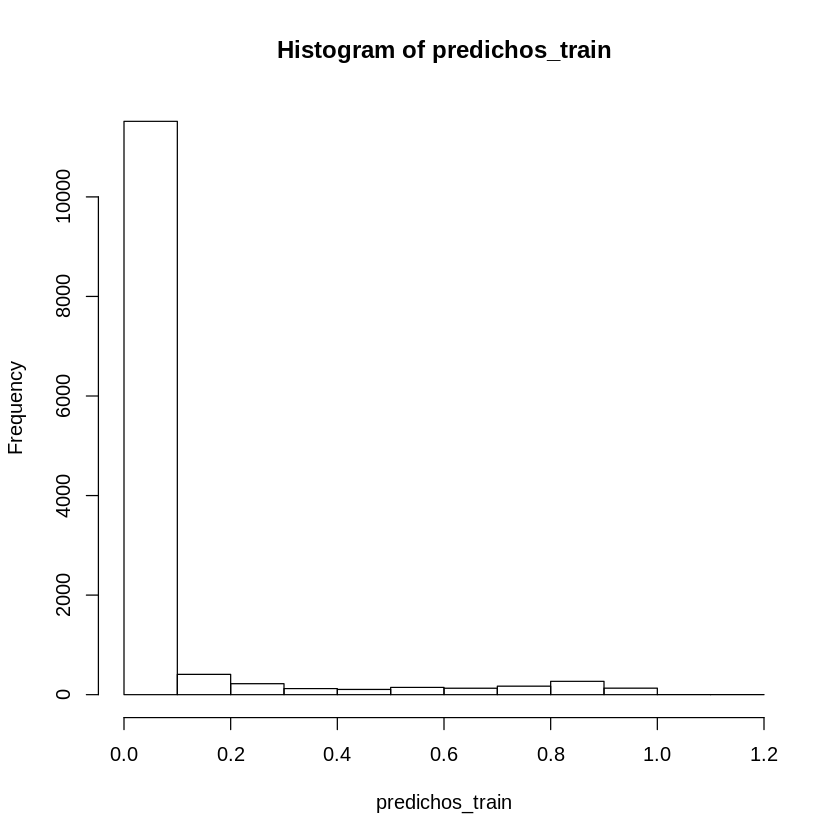

In [129]:
predichos_train <- h2o.predict(xgb, datos_train_h2o) %>%
  as.data.frame() %>% pull(predict)
hist(predichos_train)

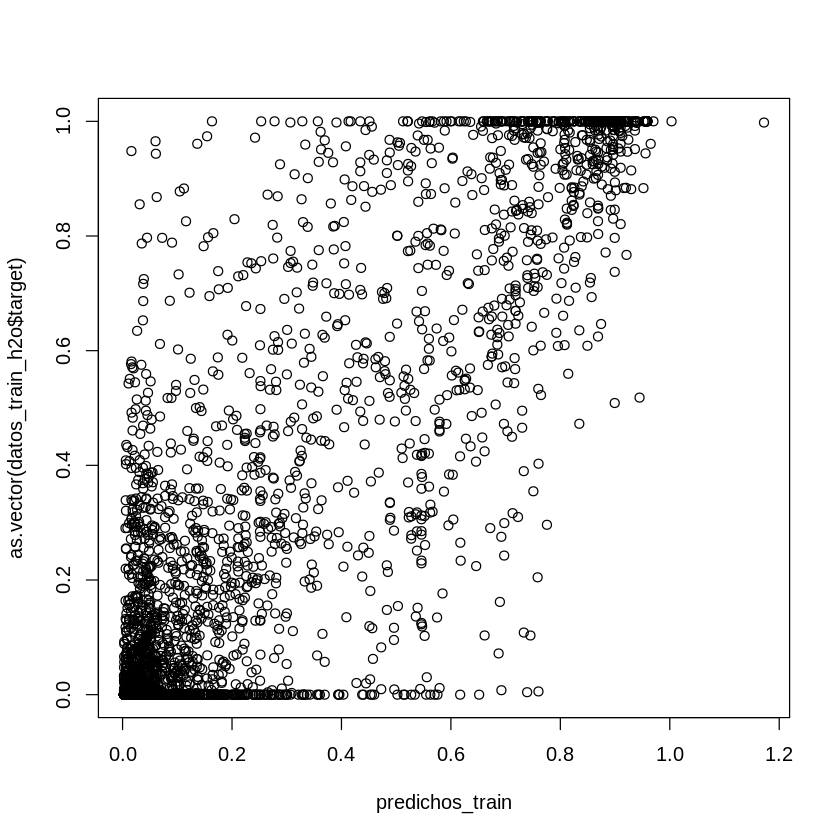

In [130]:
plot(predichos_train, as.vector(datos_train_h2o$target))

  |======================================================================| 100%


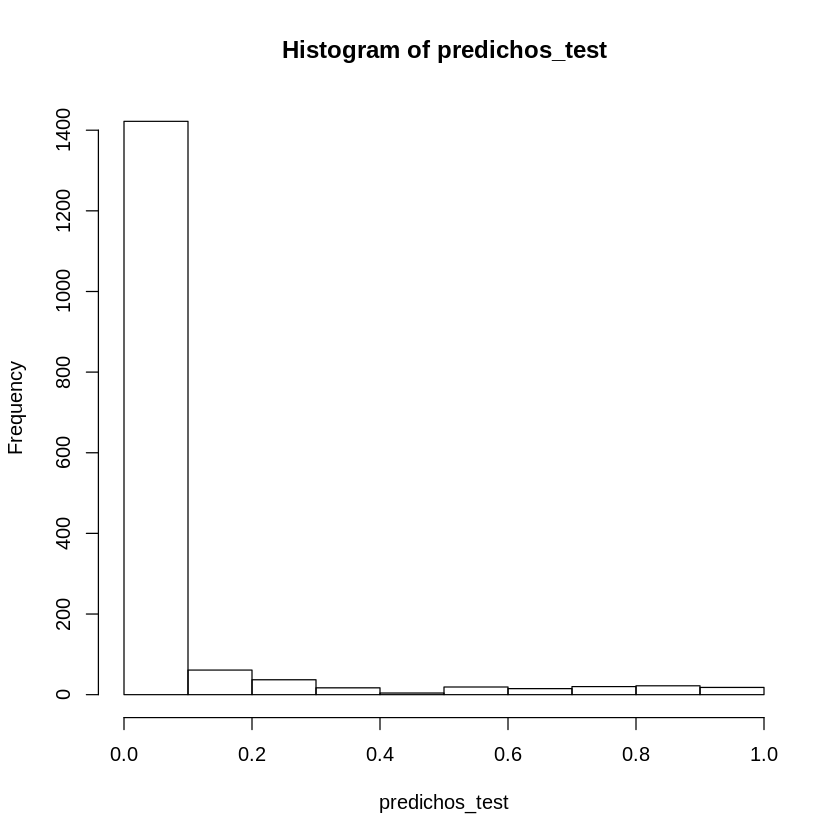

In [131]:
predichos_test <- h2o.predict(xgb, datos_test_h2o) %>%
  as.data.frame() %>% pull(predict) 
hist(predichos_test)

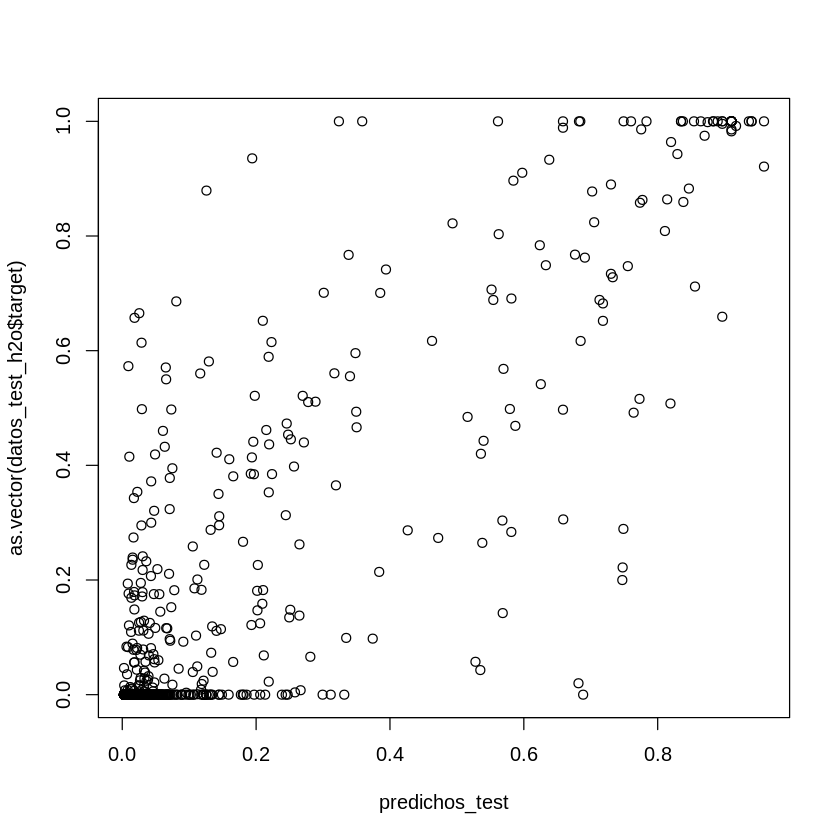

In [132]:
plot(predichos_test, as.vector(datos_test_h2o$target))

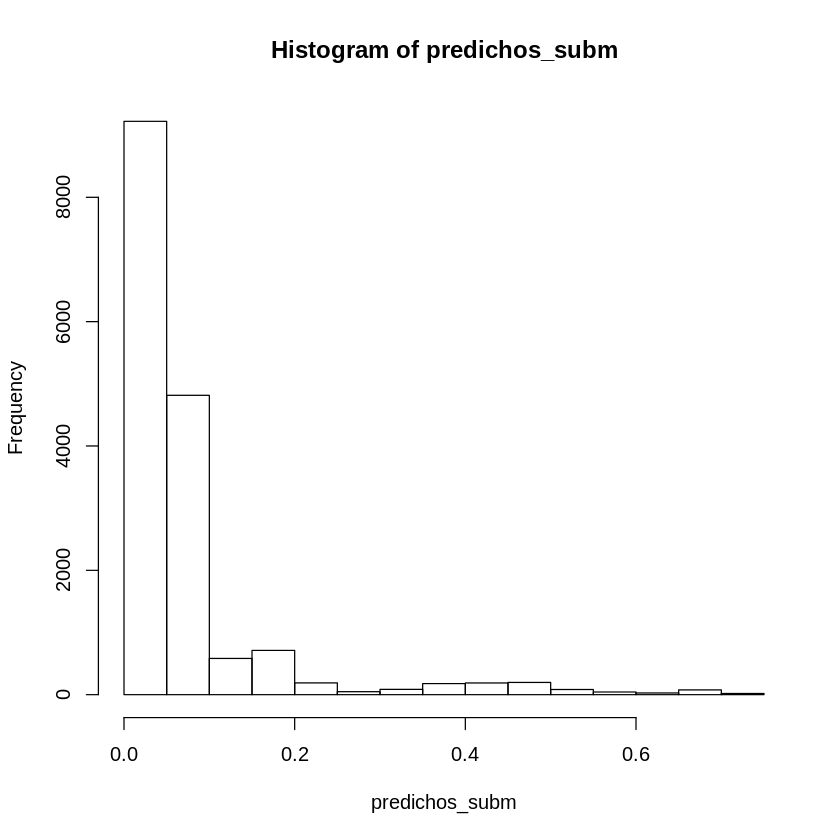

In [133]:
hist(predichos_subm)